In [2]:
%pip install pandas
!pip install pyarrow
import pandas as pd
import numpy as np
import re
from typing import Dict
from pathlib import Path
import io
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

Note: you may need to restart the kernel to use updated packages.


Wgrywanie pliku graduates-major-data.csv w taki sposób by zostawał w pamięci.

In [3]:
# --- 1. KONFIGURACJA ---
CSV_FILE = Path('./data/graduates-major-data.csv')
PARQUET_FILE = Path('./data/graduates-major-data.parquet')
warnings.filterwarnings('ignore')

# --- 2. FUNKCJA BRUTE FORCE (Wczytywanie CSV) ---
def ultra_robust_load_csv(path):
    encodings = ['cp1250', 'utf-8', 'utf-8-sig', 'latin1']
    seps = [';', ',', '\t']
    
    for enc in encodings:
        for sep in seps:
            try:
                # Test struktury
                test_df = pd.read_csv(path, encoding=enc, sep=sep, nrows=2)
                if test_df.shape[1] <= 1 and sep in [';', ',']:
                    continue

                # Wczytanie całości
                df = pd.read_csv(
                    path,
                    encoding=enc,
                    sep=sep,
                    decimal=',',
                    on_bad_lines='skip',
                    engine='c',
                    low_memory=False
                )
                
                # Czyszczenie nagłówków (usuwanie " i spacji)
                df.columns = [c.strip().replace('"', '') for c in df.columns]
                return df, f"✅ CSV wczytany pomyślnie ({enc}, '{sep}')"
            except:
                continue
    return None, "❌ Nie udało się wczytać pliku CSV."

# --- 3. GŁÓWNA LOGIKA (Wczytywanie do pamięci) ---

def get_data():
    if PARQUET_FILE.exists():
        print(f"🚀 Wczytywanie zoptymalizowanego pliku Parquet...")
        return pd.read_parquet(PARQUET_FILE)
    
    if CSV_FILE.exists():
        df, status = ultra_robust_load_csv(CSV_FILE)
        print(status)
        
        if df is not None:
            print(f"🧹 Przygotowywanie danych do formatu Parquet...")
            
            # --- KLUCZOWA POPRAWKA ---
            # Pyarrow nie lubi generycznych typów 'object'. 
            # Zamieniamy je na stringi, co rozwiązuje ArrowKeyError.
            for col in df.columns:
                if df[col].dtype == 'object':
                    df[col] = df[col].astype(str).replace('nan', None) # zamiana nan-stringów na prawdziwe braki danych
            
            print(f"💾 Zapisywanie do Parquet...")
            try:
                df.to_parquet(PARQUET_FILE, index=False, engine='pyarrow')
                return df
            except Exception as e:
                print(f"❌ Błąd zapisu Parquet: {e}")
                print("⚠️ Spróbuję zapisać jako Pickle (plan awaryjny)...")
                df.to_pickle(PARQUET_FILE.with_suffix('.pkl'))
                return df
    else:
        print(f"❌ BŁĄD: Nie znaleziono pliku {CSV_FILE}")
        return None

# --- URUCHOMIENIE ---
df = get_data()

if df is not None:
    print(f"📊 Dane gotowe w pamięci (zmienna 'df').")
    print(f"   Rozmiar: {df.shape[0]} wierszy x {df.shape[1]} kolumn.")
    # Przykładowa kolumna po automatycznej konwersji przez decimal=','
    # print(df.dtypes)

✅ CSV wczytany pomyślnie (utf-8, ';')
🧹 Przygotowywanie danych do formatu Parquet...
💾 Zapisywanie do Parquet...
📊 Dane gotowe w pamięci (zmienna 'df').
   Rozmiar: 70176 wierszy x 694 kolumn.


Bazowy indeks sukcesu (IS) na przestrzeni 60 miesięcy po uzyskaniu dyplomu vs dziedzina studiów.

📊 Obliczam indeks dla 60 miesięcy dla każdej z dziedzin.

✅ Indeks sukcesu obliczony.
                       P_DZIEDZINA     Miesiac  Indeks_Sukcesu  Miesiac_Nr
0   Dziedzina nauk humanistycznych   IS_MIES_1       -0.149387           1
8   Dziedzina nauk humanistycznych   IS_MIES_2       -0.256065           2
16  Dziedzina nauk humanistycznych   IS_MIES_3       -0.294137           3
24  Dziedzina nauk humanistycznych   IS_MIES_4       -0.337159           4
32  Dziedzina nauk humanistycznych   IS_MIES_5       -0.250852           5
40  Dziedzina nauk humanistycznych   IS_MIES_6       -0.217635           6
48  Dziedzina nauk humanistycznych   IS_MIES_7       -0.188406           7
56  Dziedzina nauk humanistycznych   IS_MIES_8       -0.139665           8
64  Dziedzina nauk humanistycznych   IS_MIES_9       -0.127778           9
72  Dziedzina nauk humanistycznych  IS_MIES_10       -0.102105          10


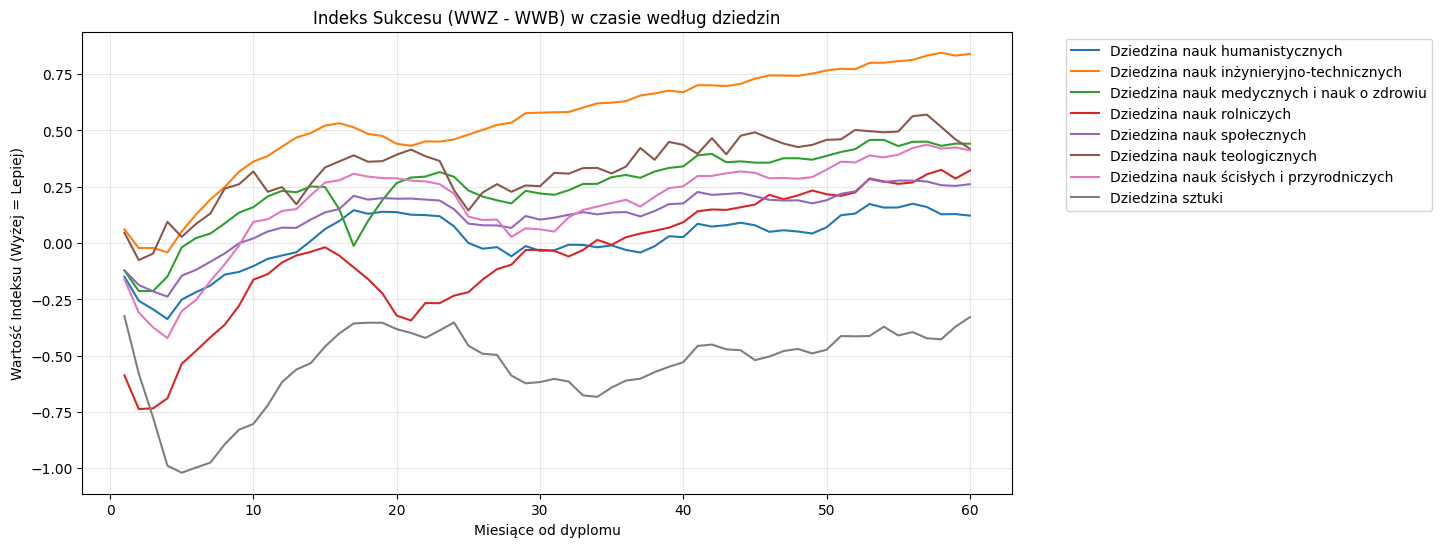

In [4]:
# 1. Pobranie list kolumn za pomocą Regex
wwz_cols = sorted(df.filter(regex=r'^P_WWZ_MIES_\d+$').columns.tolist(), 
                  key=lambda x: int(re.search(r'\d+', x).group()))
wwb_cols = sorted(df.filter(regex=r'^P_WWB_MIES_\d+$').columns.tolist(), 
                  key=lambda x: int(re.search(r'\d+', x).group()))

# Sprawdzenie czy mamy pary (WWZ i WWB dla tych samych miesięcy)
months = [re.search(r'\d+', c).group() for c in wwz_cols]

print(f"📊 Obliczam indeks dla {len(months)} miesięcy dla każdej z dziedzin.")

# 2. Obliczanie Indeksu Sukcesu dla każdego miesiąca w RAM
# Tworzymy nowe kolumny IS_MIES_X = WWZ_MIES_X - WWB_MIES_X
is_cols = []
for m in months:
    wwz_c = f'P_WWZ_MIES_{m}'
    wwb_c = f'P_WWB_MIES_{m}'
    is_c = f'IS_MIES_{m}'
    
    # Konwersja na numeric (na wszelki wypadek) i obliczenie
    df[wwz_c] = pd.to_numeric(df[wwz_c], errors='coerce')
    df[wwb_c] = pd.to_numeric(df[wwb_c], errors='coerce')
    
    df[is_c] = df[wwz_c] - df[wwb_c]
    is_cols.append(is_c)

# 3. Grupowanie według P_DZIEDZINA
# ELA ma standardowo 8-9 głównych dziedzin
dziedziny_stats = df.groupby('P_DZIEDZINA')[is_cols].mean()

# 4. Reorganizacja danych do wykresu (z formatu szerokiego na długi)
# Chcemy mieć: Dziedzina | Miesiąc | Indeks_Sukcesu
dziedziny_long = dziedziny_stats.reset_index().melt(
    id_vars='P_DZIEDZINA', 
    var_name='Miesiac', 
    value_name='Indeks_Sukcesu'
)

# Wyciągamy samą liczbę z nazwy miesiąca do sortowania
dziedziny_long['Miesiac_Nr'] = dziedziny_long['Miesiac'].str.extract('(\d+)').astype(int)
dziedziny_long = dziedziny_long.sort_values(['P_DZIEDZINA', 'Miesiac_Nr'])

print("\n✅ Indeks sukcesu obliczony.")
print(dziedziny_long.head(10))

# 5. Prosta wizualizacja (wymaga matplotlib/seaborn)
try:
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=dziedziny_long, x='Miesiac_Nr', y='Indeks_Sukcesu', hue='P_DZIEDZINA')
    plt.title('Indeks Sukcesu (WWZ - WWB) w czasie według dziedzin')
    plt.xlabel('Miesiące od dyplomu')
    plt.ylabel('Wartość Indeksu (Wyżej = Lepiej)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.show()
except ImportError:
    print("ℹ️ Zainstaluj seaborn i matplotlib, aby zobaczyć wykres.")


IS z doświadczeniem lub bez.

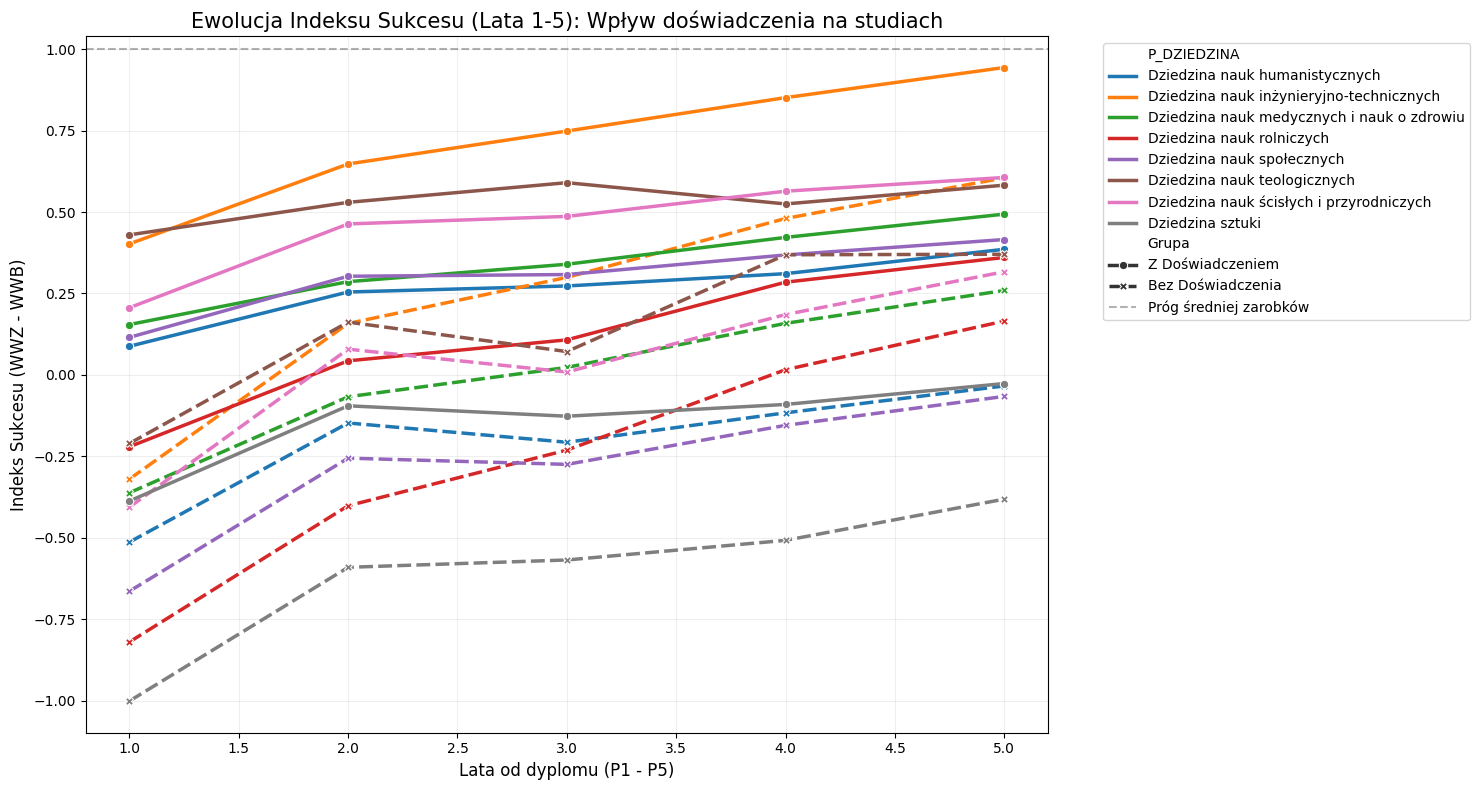

In [5]:
# 1. Przygotowanie list kolumn dla 5 lat
years = range(1, 6)
is_cols_dosw = []
is_cols_ndosw = []

# Obliczamy Indeks Sukcesu (WWZ - WWB) dla każdego roku
for y in years:
    wwz_d = f'P_WWZ_DOSW_P{y}'
    wwz_n = f'P_WWZ_NDOSW_P{y}'
    wwb_d = f'P_WWB_DOSW_P{y}'
    wwb_n = f'P_WWB_NDOSW_P{y}'
    
    is_d = f'IS_DOSW_P{y}'
    is_n = f'IS_NDOSW_P{y}'
    
    # Konwersja i obliczenia (w locie na głównym df)
    df[is_d] = pd.to_numeric(df[wwz_d], errors='coerce') - pd.to_numeric(df[wwb_d], errors='coerce')
    df[is_n] = pd.to_numeric(df[wwz_n], errors='coerce') - pd.to_numeric(df[wwb_n], errors='coerce')
    
    is_cols_dosw.append(is_d)
    is_cols_ndosw.append(is_n)

# 2. Agregacja wyników według P_DZIEDZINA
res_dosw = df.groupby('P_DZIEDZINA')[is_cols_dosw].mean().reset_index()
res_ndosw = df.groupby('P_DZIEDZINA')[is_cols_ndosw].mean().reset_index()

# 3. Przekształcenie danych do formatu "Long" dla wizualizacji
df_long_d = res_dosw.melt(id_vars='P_DZIEDZINA', var_name='Rok', value_name='Indeks')
df_long_d['Grupa'] = 'Z Doświadczeniem'

df_long_n = res_ndosw.melt(id_vars='P_DZIEDZINA', var_name='Rok', value_name='Indeks')
df_long_n['Grupa'] = 'Bez Doświadczenia'

# Połączenie i oczyszczenie numeru roku
final_plot_df = pd.concat([df_long_d, df_long_n])
final_plot_df['Rok_Nr'] = final_plot_df['Rok'].str.extract('(\d+)').astype(int)

# 4. Wizualizacja porównawcza (Wykres liniowy dla 8 dziedzin)
plt.figure(figsize=(15, 8))
g = sns.lineplot(
    data=final_plot_df, 
    x='Rok_Nr', y='Indeks', 
    hue='P_DZIEDZINA', style='Grupa', 
    markers=True, dashes=True, linewidth=2.5
)

plt.title('Ewolucja Indeksu Sukcesu (Lata 1-5): Wpływ doświadczenia na studiach', fontsize=15)
plt.xlabel('Lata od dyplomu (P1 - P5)', fontsize=12)
plt.ylabel('Indeks Sukcesu (WWZ - WWB)', fontsize=12)
plt.axhline(1.0, color='black', linestyle='--', alpha=0.3, label='Próg średniej zarobków')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

Model RF badający wpływ zmiennych na IS po 5 latach.

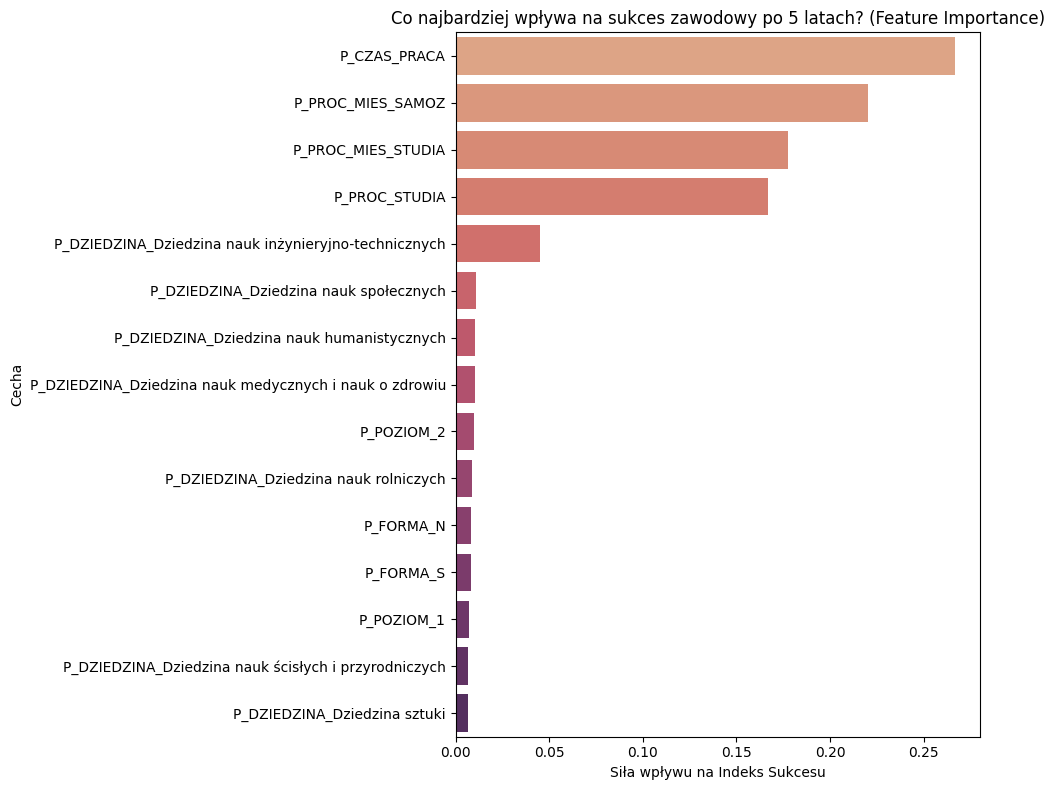

✅ Model zakończył analizę.
                                                Cecha   Waznosc
2                                        P_CZAS_PRACA  0.266724
3                                   P_PROC_MIES_SAMOZ  0.220279
1                                  P_PROC_MIES_STUDIA  0.177418
0                                       P_PROC_STUDIA  0.166588
5   P_DZIEDZINA_Dziedzina nauk inżynieryjno-techni...  0.044935
8              P_DZIEDZINA_Dziedzina nauk społecznych  0.010685
4          P_DZIEDZINA_Dziedzina nauk humanistycznych  0.010600
6   P_DZIEDZINA_Dziedzina nauk medycznych i nauk o...  0.010480
13                                         P_POZIOM_2  0.009542
7               P_DZIEDZINA_Dziedzina nauk rolniczych  0.008581


In [6]:
# 1. Lista zweryfikowanych cech (Features), które istnieją w Twoim pliku
features = [
    'P_DZIEDZINA',          # Dziedzina nauki
    'P_POZIOM',            # Poziom studiów (I, II, jednolite)
    'P_FORMA',             # Forma (stacjonarne / niestacjonarne)
    'P_PROC_STUDIA',       # % osób pracujących na studiach
    'P_PROC_MIES_STUDIA',  # Intensywność pracy na studiach (% miesięcy)
    'P_CZAS_PRACA',        # Czas szukania pierwszej pracy
    'P_CZY_PRACA_MUNDUR',  # Czy praca w służbach mundurowych
    'P_PROC_MIES_SAMOZ'    # Intensywność samozatrudnienia
]

# 2. Przygotowanie danych i celu (Target)
# Obliczamy Indeks Sukcesu dla 5. roku (P5) dla grupy z doświadczeniem
df['IS_TARGET'] = pd.to_numeric(df['P_WWZ_DOSW_P5'], errors='coerce') - \
                  pd.to_numeric(df['P_WWB_DOSW_P5'], errors='coerce')

# Wybieramy dane i usuwamy wiersze, gdzie nie udało się obliczyć indeksu (np. brak danych po 5 latach)
df_model = df[features + ['IS_TARGET']].dropna(subset=['IS_TARGET'])

X_raw = df_model[features]
y = df_model['IS_TARGET']

# 3. Kodowanie zmiennych tekstowych (One-Hot Encoding)
X = pd.get_dummies(X_raw, columns=['P_DZIEDZINA', 'P_POZIOM', 'P_FORMA', 'P_CZY_PRACA_MUNDUR'])

# Uzupełnienie ewentualnych braków w cechach średnią
X = X.fillna(X.median())

# 4. Trenowanie modelu
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# 5. Ranking ważności
importance = pd.DataFrame({
    'Cecha': X.columns,
    'Waznosc': model.feature_importances_
}).sort_values('Waznosc', ascending=False)

# 6. Wizualizacja
plt.figure(figsize=(10, 8))
sns.barplot(data=importance.head(15), x='Waznosc', y='Cecha', palette='flare')
plt.title('Co najbardziej wpływa na sukces zawodowy po 5 latach? (Feature Importance)')
plt.xlabel('Siła wpływu na Indeks Sukcesu')
plt.tight_layout()
plt.show()

print("✅ Model zakończył analizę.")
print(importance.head(10))

Najlepsza iteracja modelu OLS z badaniem interakcji zmiennych – R^2 na poziomie 20%. Można spróbować pobawić się ze zmiennymi.

In [23]:
# 1. Przygotowanie danych
# Dodajemy P_N_SEMESTR (liczba) i P_WOJ (kategoria)
numerical_cols = ['P_PROC_MIES_STUDIA', 'P_CZAS_PRACA', 'P_PROC_MIES_SAMOZ', 
                  'P_PROC_MIES_BEZR', 'P_N_SEMESTR']
categorical_cols = ['P_DZIEDZINA', 'P_POZIOM', 'P_FORMA', 'P_WOJ']  

df_v4 = df.copy()

# Konwersja WOJ na string, aby get_dummies zadziałało poprawnie
df_v4['P_WOJ'] = df_v4['P_WOJ'].astype(str)

for col in numerical_cols:
    df_v4[col] = pd.to_numeric(df_v4[col], errors='coerce')

df_v4['IS_TARGET'] = pd.to_numeric(df_v4['P_WWZ_DOSW_P5'], errors='coerce') - \
                      pd.to_numeric(df_v4['P_WWB_DOSW_P5'], errors='coerce')

df_clean = df_v4[categorical_cols + numerical_cols + ['IS_TARGET']].dropna()

# 2. Encoding i Interakcje
X = pd.get_dummies(df_clean[categorical_cols + numerical_cols], columns=categorical_cols, drop_first=True)

# Dodajemy sprawdzoną interakcję Dziedzina x Praca
for col in [c for c in X.columns if 'P_DZIEDZINA' in c]:
    X[f'INT_{col[-10:]}_x_Praca'] = X[col] * X['P_PROC_MIES_STUDIA']

# 3. Model OLS
X_ols = sm.add_constant(X.astype(float))
y_ols = df_clean['IS_TARGET'].astype(float)

model_v4 = sm.OLS(y_ols, X_ols).fit()

# 4. Analiza wyników
print(f"📊 Model v4 (Semestry + Województwa) R-squared: {model_v4.rsquared:.4f}")
print("-" * 50)
res_v4 = pd.DataFrame({'Coef': model_v4.params, 'P': model_v4.pvalues})
sig_v4 = res_v4[res_v4['P'] < 0.05].sort_values('Coef', ascending=False)

print("✅ Najsilniejsze istotne zmienne w nowym modelu:")
print(sig_v4.head(15))

📊 Model v4 (Semestry + Województwa) R-squared: 0.2029
--------------------------------------------------
✅ Najsilniejsze istotne zmienne w nowym modelu:
                                                        Coef             P
const                                               1.140660  1.608306e-36
P_DZIEDZINA_Dziedzina nauk inżynieryjno-technic...  0.275052  4.274133e-14
P_WOJ_18.0                                          0.272179  4.704619e-13
P_WOJ_6.0                                           0.207582  1.845872e-09
P_WOJ_26.0                                          0.135142  2.546808e-03
P_DZIEDZINA_Dziedzina nauk ścisłych i przyrodni...  0.135009  5.676475e-03
P_WOJ_28.0                                          0.134380  1.800428e-03
P_POZIOM_JM                                         0.131000  1.861215e-02
P_FORMA_S                                           0.112509  1.861377e-11
P_WOJ_20.0                                          0.081989  4.749264e-02
P_PROC_MIES_SAMOZ     

In [ ]:
Obliczanie reszt modelu. Nie jest jakiś świetny, ale pozwala na dalszą analizę.

In [14]:
# 1. Obliczamy przewidywane wartości i błędy
df_clean['PREDICTED_IS'] = model_v4.predict(X_ols)
df_clean['RESIDUAL'] = df_clean['IS_TARGET'] - df_clean['PREDICTED_IS']

# 2. Standaryzacja rezyduów (żeby łatwiej ocenić skalę błędu)
df_clean['RESIDUAL_STD'] = (df_clean['RESIDUAL'] - df_clean['RESIDUAL'].mean()) / df_clean['RESIDUAL'].std()

# 3. Wyciągamy TOP 10 kierunków "ponad stan" (pozytywne zaskoczenia)
# Załóżmy, że masz kolumnę 'P_NAZWA_KIERUNKU' lub podobną
top_outperformers = df_clean.sort_values('RESIDUAL', ascending=False).head(10)

# 4. Wyciągamy TOP 10 kierunków "poniżej oczekiwań"
top_underperformers = df_clean.sort_values('RESIDUAL', ascending=True).head(10)

print("🏆 KIERUNKI 'PONAD STAN' (Największe pozytywne rezydua):")
# Wyświetlamy najważniejsze informacje dla tych rekordów
cols_to_show = ['P_DZIEDZINA', 'IS_TARGET', 'PREDICTED_IS', 'RESIDUAL']
# Jeśli masz nazwę kierunku/uczelni w df, dodaj ją tutaj:
# cols_to_show = ['P_NAZWA_KIERUNKU', 'P_NAZWA_UCZELNI'] + cols_to_show

print(top_outperformers[cols_to_show])

print("\n📉 KIERUNKI 'PONIŻEJ OCZEKIWAŃ':")
print(top_underperformers[cols_to_show])

🏆 KIERUNKI 'PONAD STAN' (Największe pozytywne rezydua):
                                    P_DZIEDZINA  IS_TARGET  PREDICTED_IS  \
27182                Dziedzina nauk społecznych       1.65     -1.479324   
11223  Dziedzina nauk inżynieryjno-technicznych       3.60      0.762199   
7061   Dziedzina nauk inżynieryjno-technicznych       1.60     -1.182788   
32485                          Dziedzina sztuki       0.82     -1.925830   
20142  Dziedzina nauk ścisłych i przyrodniczych       1.37     -1.245826   
22791  Dziedzina nauk ścisłych i przyrodniczych       1.33     -1.259127   
18977                Dziedzina nauk społecznych       2.66      0.137480   
7528   Dziedzina nauk inżynieryjno-technicznych       1.25     -1.204263   
31894  Dziedzina nauk ścisłych i przyrodniczych       3.45      1.001721   
26574                Dziedzina nauk społecznych       0.57     -1.877818   

       RESIDUAL  
27182  3.129324  
11223  2.837801  
7061   2.782788  
32485  2.745830  
20142  2.615826  

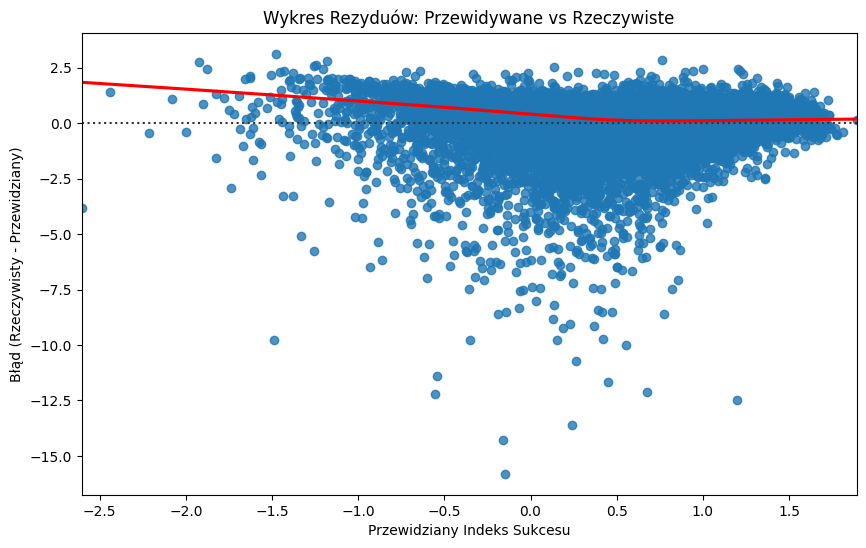

In [15]:
plt.figure(figsize=(10, 6))
sns.residplot(x=df_clean['PREDICTED_IS'], y=df_clean['IS_TARGET'], lowess=True, line_kws={'color': 'red'})
plt.title('Wykres Rezyduów: Przewidywane vs Rzeczywiste')
plt.xlabel('Przewidziany Indeks Sukcesu')
plt.ylabel('Błąd (Rzeczywisty - Przewidziany)')
plt.show()

Ranking uzcelni na podstawie IS.

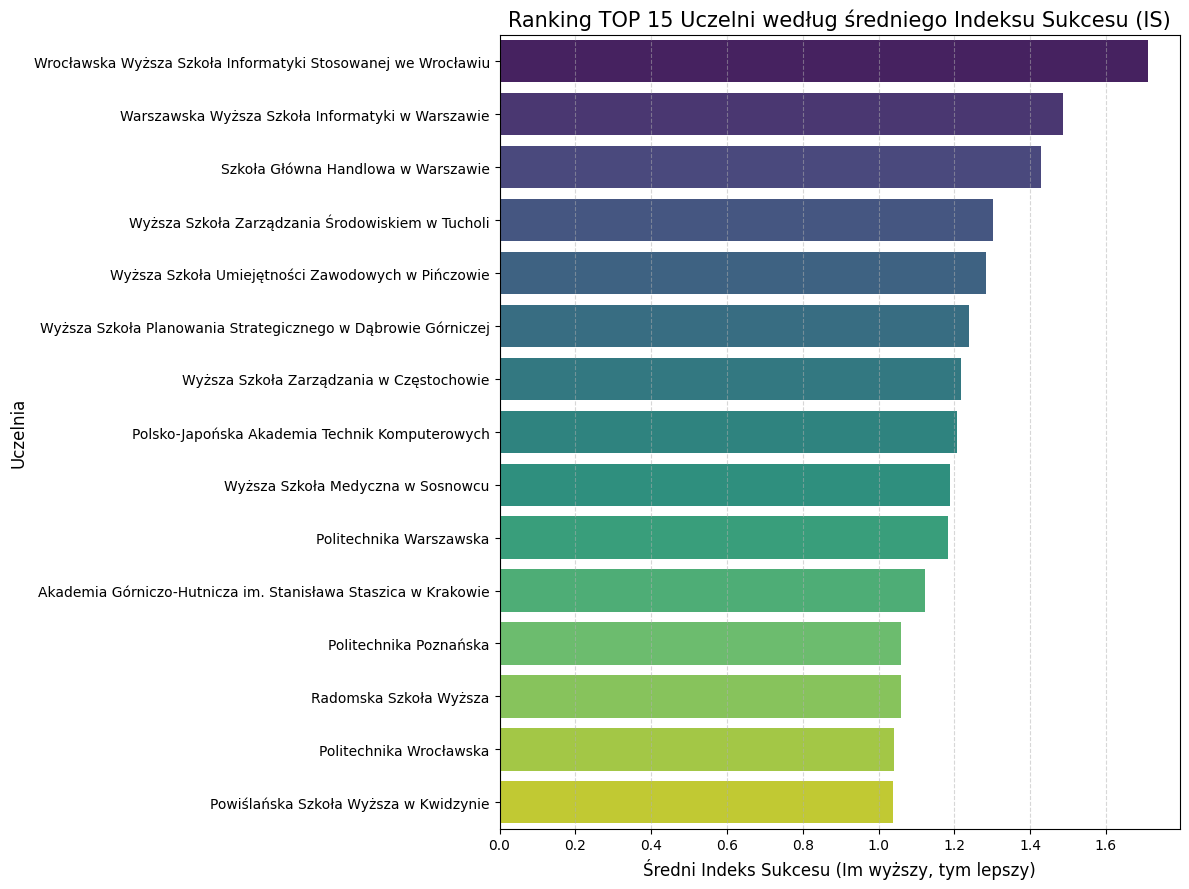

🏆 Najlepsze uczelnie pod kątem ekonomicznego sukcesu absolwentów:
                                                    Sredni_IS  \
P_NAZWA_UCZELNI                                                 
Wrocławska Wyższa Szkoła Informatyki Stosowanej...   1.710000   
Warszawska Wyższa Szkoła Informatyki w Warszawie     1.486667   
Szkoła Główna Handlowa w Warszawie                   1.429744   
Wyższa Szkoła Zarządzania Środowiskiem w Tucholi     1.301000   
Wyższa Szkoła Umiejętności Zawodowych w Pińczowie    1.284000   
Wyższa Szkoła Planowania Strategicznego w Dąbro...   1.237917   
Wyższa Szkoła Zarządzania w Częstochowie             1.218750   
Polsko-Japońska Akademia Technik Komputerowych       1.206604   
Wyższa Szkoła Medyczna w Sosnowcu                    1.189091   
Politechnika Warszawska                              1.184124   
Akademia Górniczo-Hutnicza im. Stanisława Stasz...   1.123439   
Politechnika Poznańska                               1.060147   
Radomska Szkoła Wyższa  

In [18]:
# 1. Definiujemy listy cech, dodając nazwę uczelni do zestawu danych
categorical_features = ['P_DZIEDZINA', 'P_POZIOM', 'P_FORMA', 'P_WOJ']
numerical_features = [
    'P_PROC_MIES_STUDIA', 
    'P_CZAS_PRACA', 
    'P_PROC_MIES_SAMOZ',
    'P_PROC_MIES_BEZR',
    'P_N_SEMESTR'
]
uczelnia_col = 'P_NAZWA_UCZELNI'

# 2. Przygotowanie danych z zachowaniem nazwy uczelni
df_ana = df.copy()

# Konwersja numeryczna
for col in numerical_features:
    df_ana[col] = pd.to_numeric(df_ana[col], errors='coerce')

# Obliczamy Indeks Sukcesu (IS)
df_ana['IS_TARGET'] = pd.to_numeric(df_ana['P_WWZ_DOSW_P5'], errors='coerce') - \
                       pd.to_numeric(df_ana['P_WWB_DOSW_P5'], errors='coerce')

# KLUCZOWY MOMENT: Wybieramy kolumny do analizy, w tym P_NAZWA_UCZELNI
cols_to_keep = categorical_features + numerical_features + ['IS_TARGET', uczelnia_col]
df_final_ana = df_ana[cols_to_keep].dropna()

# 3. Agregacja danych po uczelniach
ranking_uczelni = df_final_ana.groupby(uczelnia_col).agg({
    'IS_TARGET': ['mean', 'std', 'count'],
    'P_PROC_MIES_STUDIA': 'mean',
    'P_PROC_MIES_SAMOZ': 'mean'
})

# Zmiana nazw kolumn na płaskie
ranking_uczelni.columns = ['Sredni_IS', 'Odchylenie_IS', 'Liczba_Kierunkow', 'Srednia_Praca_Studia', 'Srednia_Samozatrudnienie']

# 4. Filtrowanie - minimum 5 kierunków dla wiarygodności
ranking_filtered = ranking_uczelni[ranking_uczelni['Liczba_Kierunkow'] >= 5].sort_values('Sredni_IS', ascending=False)

# 5. Wizualizacja TOP 15
plt.figure(figsize=(12, 9))
top_15 = ranking_filtered.head(15)

sns.barplot(
    x=top_15['Sredni_IS'], 
    y=top_15.index, 
    hue=top_15.index, 
    palette='viridis', 
    legend=False
)

plt.title('Ranking TOP 15 Uczelni według średniego Indeksu Sukcesu (IS)', fontsize=15)
plt.xlabel('Średni Indeks Sukcesu (Im wyższy, tym lepszy)', fontsize=12)
plt.ylabel('Uczelnia', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Wyświetlenie tabeli wynikowej
print("🏆 Najlepsze uczelnie pod kątem ekonomicznego sukcesu absolwentów:")
print(ranking_filtered[['Sredni_IS', 'Liczba_Kierunkow', 'Srednia_Praca_Studia']].head(15))